In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Found 188 CSV files


Loading datasets:   0%|          | 0/188 [00:00<?, ?it/s]

Loading datasets:   6%|▋         | 12/188 [00:00<00:01, 116.04it/s]


Dataset sizes:
Total samples: 14344
Train: 10040 (70.0%)
Validation: 2152 (15.0%)
Test: 2152 (15.0%)

Visualizing sample datapoints from training set...


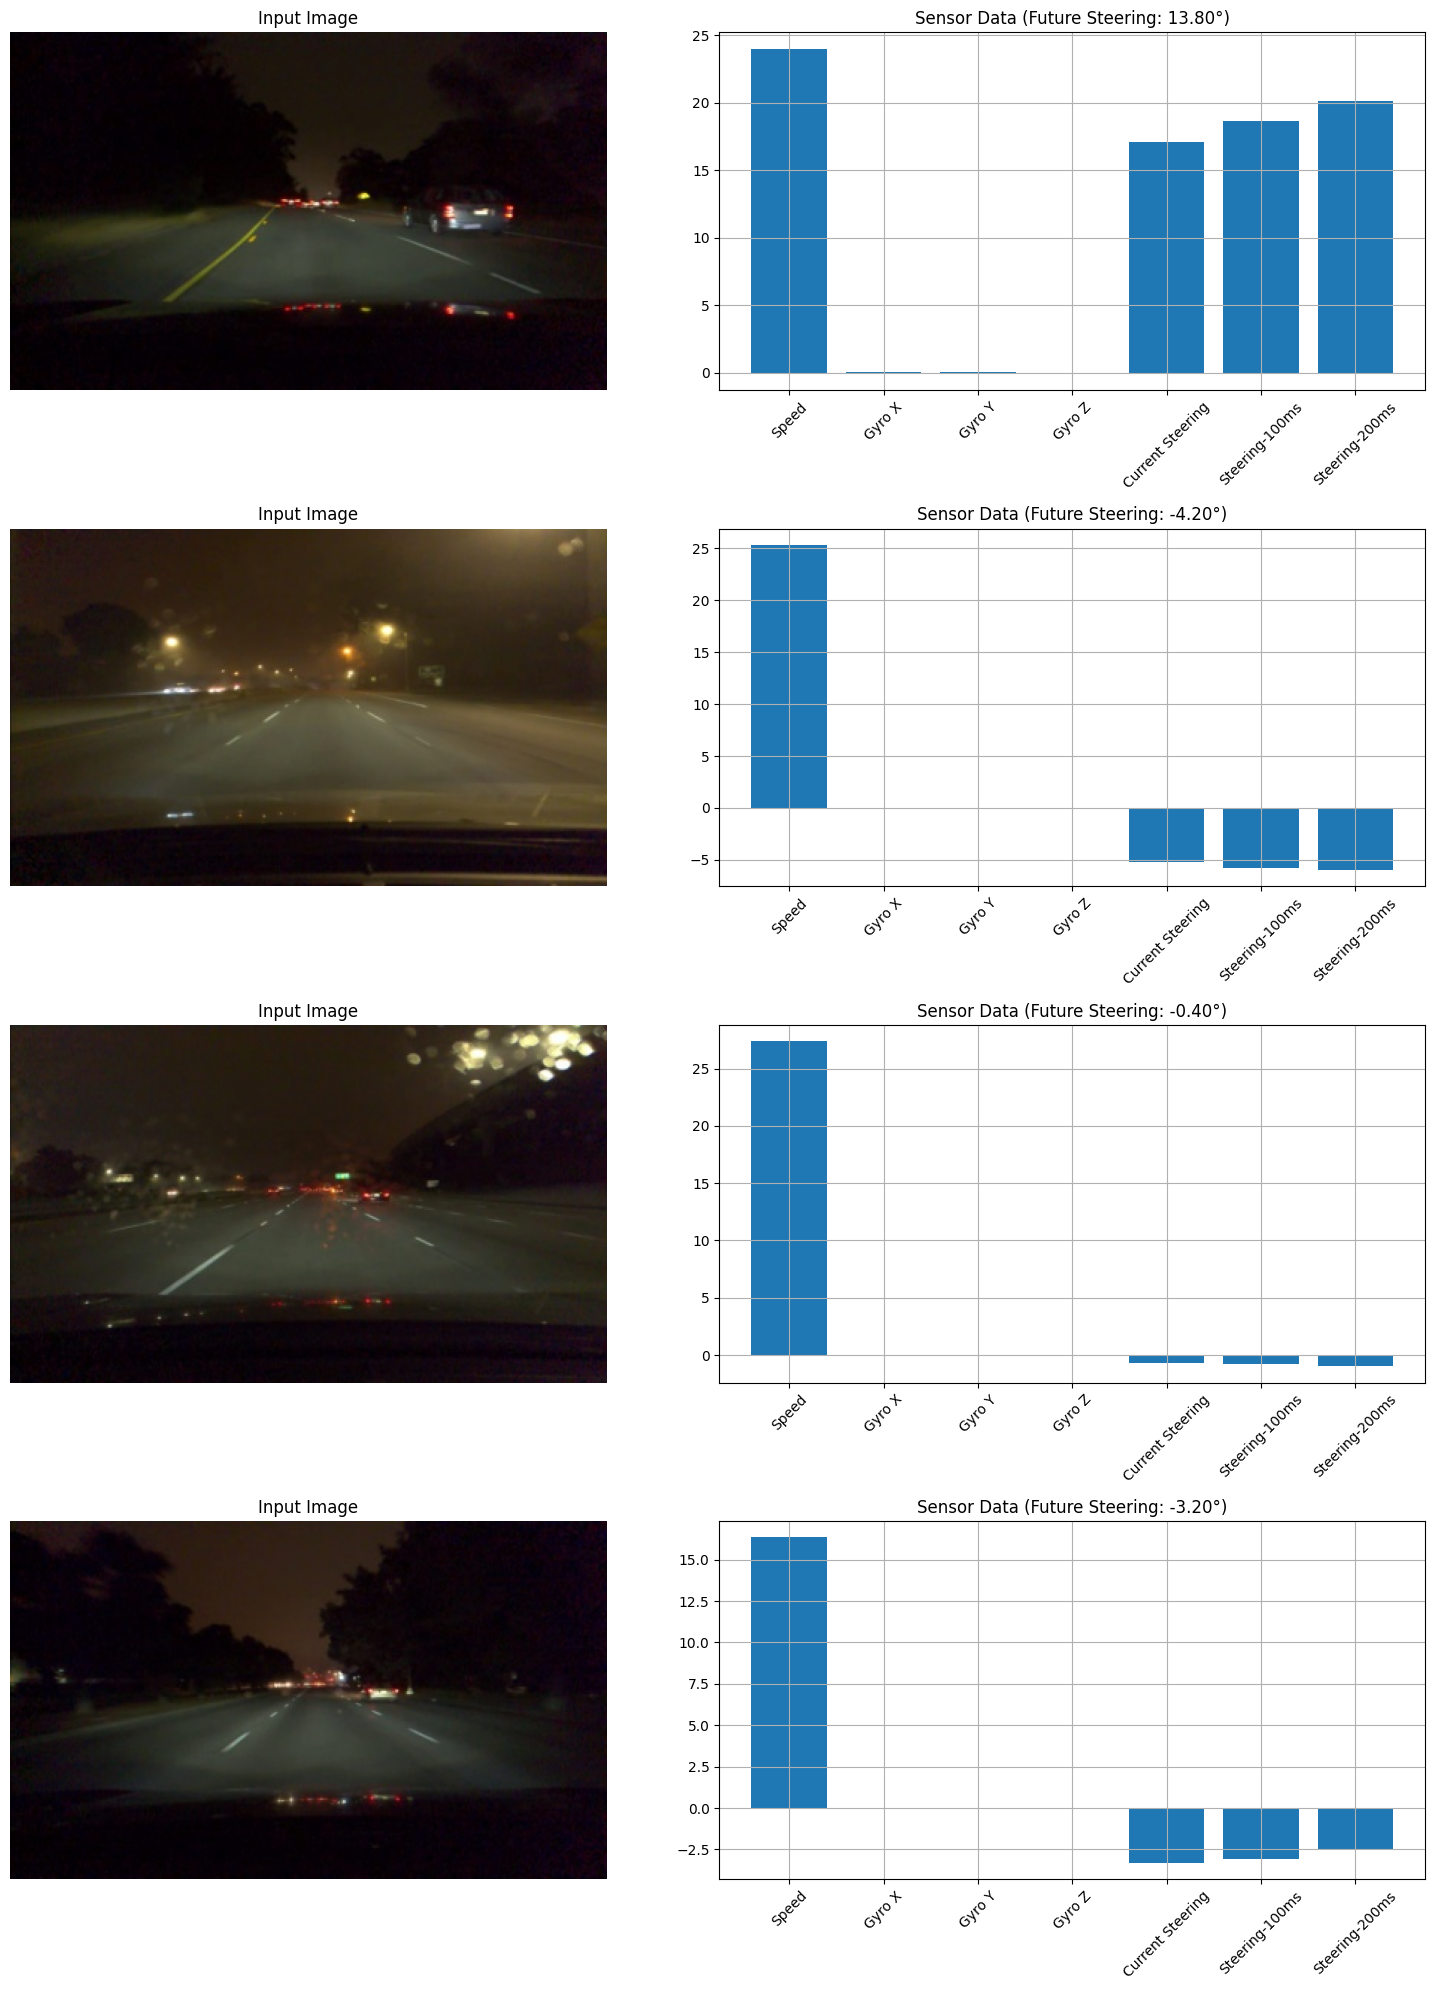

In [19]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files and frame folders

class DrivingDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(DATA_DIR, f"{filename[:-4]}_frames")
        
        #print(f"CSV file: {csv_file}")
        #print(f"Frames directory: {self.frames_dir}")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get frame index from data
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        
        # Load frame image
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        frame = Image.open(frame_path).convert('RGB')
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        # Get current sensor data (inputs)
        speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
        
        # Add steering history to sensor data
        current_data = torch.tensor([
            speed_value,
            row['gyro_x'], row['gyro_y'], row['gyro_z'],
            row['current_steering'],
            row['steering_angle_prev_100ms'],  # Add 100ms history
            row['steering_angle_prev_200ms'],  # Add 200ms history
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image, sensor_data, target = dataset[idx]
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization with updated labels
        sensor_labels = [
            'Speed', 
            'Gyro X', 'Gyro Y', 'Gyro Z',
            'Current Steering',
            'Steering-100ms',  # Add label for 100ms history
            'Steering-200ms',  # Add label for 200ms history
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

# Create datasets for each segment
datasets = []
counter = 0
for csv_file in tqdm(csv_files, desc="Loading datasets"):
    try:
        if (counter > 11):
            break
        dataset = DrivingDataset(csv_file)
        datasets.append(dataset)
        #print(f"Successfully loaded dataset from {csv_file}")
        counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
total_len = len(full_dataset)
train_end = int(0.7 * total_len) # from 0.7 to 0.85
val_end = int(0.85 * total_len) # from 0.85 to 1

train_dataset = Subset(full_dataset, list(range(0, train_end))) # from 0 to 0.7
val_dataset = Subset(full_dataset, list(range(train_end, val_end))) # from 0.7 to 0.85
test_dataset = Subset(full_dataset, list(range(val_end, total_len))) # from 0.85 to 1

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting future steering angles (t+200ms) from current dashcam images and sensor data.
    Based on NVIDIA's PilotNet architecture with additional sensor inputs.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()

        # Number of sensor inputs (all current data)
        # speed (1), gyro(3), accel(3), velocity(3), current_steering(1)
        # steering_angle_prev_100ms(1), steering_angle_prev_200ms(1) = 13
        self.sensor_input_size = 7

        # Convolutional layers for image processing
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Sensor processing layers
        self.sensor_layers = nn.Sequential(
            nn.Linear(self.sensor_input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )

        # Placeholder for combined layers (will update in _calculate_conv_output_size)
        self.combined_layers = nn.Sequential(
            nn.Linear(1, 128),  # Placeholder
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Predicting future steering angle
        )

        # Calculate the correct input size for combined layers
        self._calculate_conv_output_size()

    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        x = torch.zeros(1, 3, 260, 346)
        x = self.conv_layers(x)
        conv_flat_size = x.numel() // x.size(0)

        # Update the first linear layer in combined_layers
        combined_input_size = conv_flat_size + 64  # 64 is from sensor_layers output
        self.combined_layers[0] = nn.Linear(combined_input_size, 128)

        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened conv features size: {conv_flat_size}")
        print(f"Combined input size: {combined_input_size}")

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        image: Tensor of shape (B, 3, H, W)
        sensor_data: Tensor of shape (B, sensor_input_size)
        Returns: Predicted steering angle at t+200ms
        """
        # Process image through CNN
        x_img = self.conv_layers(image)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten CNN features

        # Process sensor data
        x_sensor = self.sensor_layers(sensor_data)

        # Combine image and sensor features
        x_combined = torch.cat([x_img, x_sensor], dim=1)
        
        # Predict future steering angle
        future_steering = self.combined_layers(x_combined)
        return future_steering

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

In [22]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Future Ground Truth')
    plt.plot(all_preds[:100], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

In [23]:
# Initialize and train
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_CNN2.pth')
print("\nModel saved to 'v4_CNN2.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)

Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

Starting training...

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Ti SUPER
Device memory: 17.17 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 157/157 [00:21<00:00,  7.31it/s, loss=1.02] 


Epoch 1: Train Loss: 4.4650, Val Loss: 2.4187


Epoch 2/50: 100%|██████████| 157/157 [00:16<00:00,  9.62it/s, loss=2.9]  


Epoch 2: Train Loss: 2.2620, Val Loss: 1.5949


Epoch 3/50:  10%|█         | 16/157 [00:02<00:20,  6.99it/s, loss=1.38]


KeyboardInterrupt: 


=== Processing 1Hz data ===
Looking for data in: e:\SteerNet\data_synced_1hz

Found 188 CSV files for 1Hz
Limiting to 60 frames per video for fair comparison


Loading 1Hz datasets:  56%|█████▋    | 106/188 [00:00<00:00, 527.33it/s]

CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-0

Loading 1Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 520.25it/s]


CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_34.csv
Frames directory: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_34_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_34.csv
CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_35.csv
Frames directory: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_35_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_35.csv
CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_36.csv
Frames directory: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_36_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_2018-08-06--10-04-53_36.csv
CSV file: e:\SteerNet\data_synced_1hz\b0c9d2329ad1606b_201

Epoch 1/50: 100%|██████████| 123/123 [00:08<00:00, 14.08it/s, loss=6.87]   


Epoch 1: Train Loss: 257.5364, Val Loss: 22.4825


Epoch 2/50: 100%|██████████| 123/123 [00:08<00:00, 14.16it/s, loss=565]    


Epoch 2: Train Loss: 213.8042, Val Loss: 74.9672


Epoch 3/50: 100%|██████████| 123/123 [00:08<00:00, 13.98it/s, loss=33.6]  


Epoch 3: Train Loss: 190.8015, Val Loss: 121.8446


Epoch 4/50: 100%|██████████| 123/123 [00:08<00:00, 14.51it/s, loss=304]    


Epoch 4: Train Loss: 177.1746, Val Loss: 45.8883


Epoch 5/50: 100%|██████████| 123/123 [00:08<00:00, 14.39it/s, loss=14.8]   


Epoch 5: Train Loss: 159.8791, Val Loss: 186.5039


Epoch 6/50: 100%|██████████| 123/123 [00:08<00:00, 13.99it/s, loss=172]    


Epoch 6: Train Loss: 146.3290, Val Loss: 211.8098


Epoch 7/50: 100%|██████████| 123/123 [00:08<00:00, 14.50it/s, loss=19.9]  


Epoch 7: Train Loss: 138.2488, Val Loss: 53.8558


Epoch 8/50: 100%|██████████| 123/123 [00:08<00:00, 14.44it/s, loss=16.6]  


Epoch 8: Train Loss: 130.0312, Val Loss: 154.9759


Epoch 9/50: 100%|██████████| 123/123 [00:08<00:00, 14.05it/s, loss=11.9]   


Epoch 9: Train Loss: 117.2225, Val Loss: 942.5333
Early stopping triggered at epoch 9


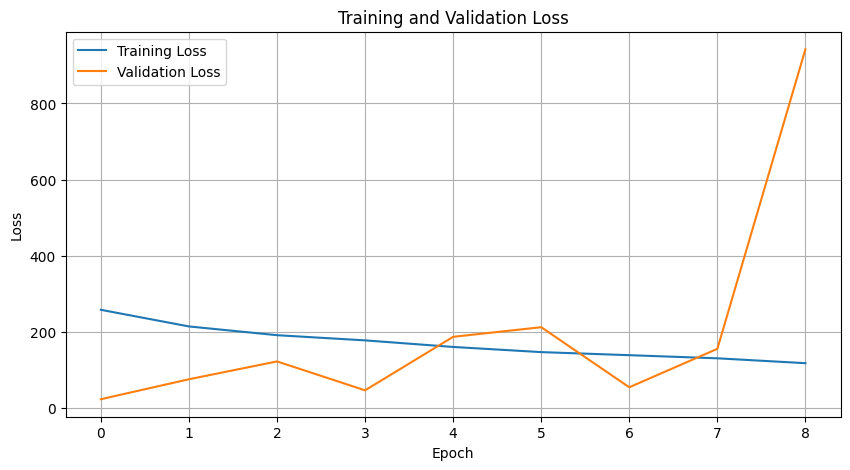

Model saved to 'v4_CNN_1hz.pth'

=== Processing 2Hz data ===
Looking for data in: e:\SteerNet\data_synced_2hz

Found 188 CSV files for 2Hz
Limiting to 60 frames per video for fair comparison


Loading 2Hz datasets:  45%|████▌     | 85/188 [00:00<00:00, 426.73it/s]

CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-0

Loading 2Hz datasets:  97%|█████████▋| 182/188 [00:00<00:00, 463.74it/s]

CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-0

Loading 2Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 450.05it/s]


CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_6.csv
Frames directory: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--14-55-39_6.csv
CSV file: e:\SteerNet\data_synced_2hz\b0c9d2329ad1606b_2018-08-17--

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=6.22]   


Epoch 1: Train Loss: 139.3220, Val Loss: 45.1694


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.67it/s, loss=5.42]   


Epoch 2: Train Loss: 111.9856, Val Loss: 14.3631


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.26it/s, loss=60.2]  


Epoch 3: Train Loss: 97.7426, Val Loss: 25.7656


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.66it/s, loss=15.2]   


Epoch 4: Train Loss: 88.4933, Val Loss: 9.6177


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.70it/s, loss=10.9]  


Epoch 5: Train Loss: 76.4764, Val Loss: 24.3965


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=3.28]  


Epoch 6: Train Loss: 70.7321, Val Loss: 39.2770


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.59it/s, loss=13.7]  


Epoch 7: Train Loss: 71.0097, Val Loss: 52.3473


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=8.92]  


Epoch 8: Train Loss: 62.6867, Val Loss: 34.9025


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=36]    


Epoch 9: Train Loss: 66.8691, Val Loss: 24.1899


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.56it/s, loss=10.4]   


Epoch 10: Train Loss: 60.4168, Val Loss: 29.5843


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.56it/s, loss=23.5]   


Epoch 11: Train Loss: 57.2348, Val Loss: 30.1359


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=18.7]


Epoch 12: Train Loss: 52.7256, Val Loss: 16.3195
Early stopping triggered at epoch 12


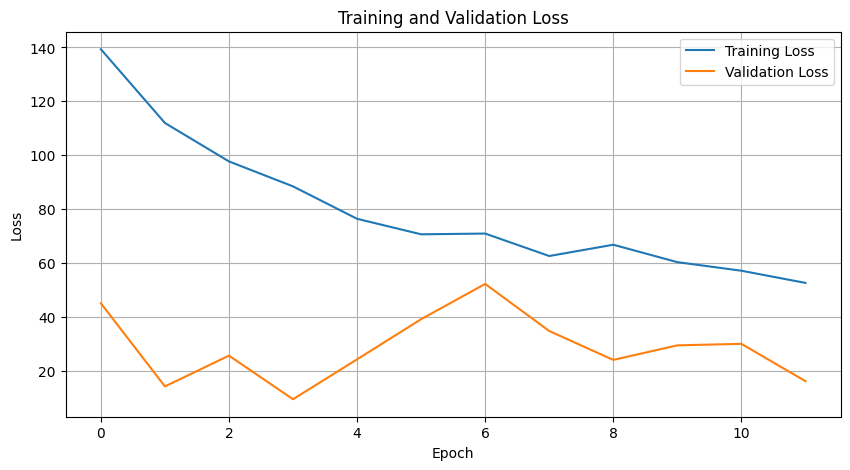

Model saved to 'v4_CNN_2hz.pth'

=== Processing 4Hz data ===
Looking for data in: e:\SteerNet\data_synced_4hz

Found 188 CSV files for 4Hz
Limiting to 60 frames per video for fair comparison


Loading 4Hz datasets:  22%|██▏       | 41/188 [00:00<00:00, 398.12it/s]

CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-0

Loading 4Hz datasets:  65%|██████▍   | 122/188 [00:00<00:00, 382.94it/s]

CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_38.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_38_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_38.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_39.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_39_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_39.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_40.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_40_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-02--08-34-47_40.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_201

Loading 4Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 393.86it/s]


CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_29.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_29_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_29.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_30.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_30_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_30.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_31.csv
Frames directory: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_31_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_2018-08-17--12-07-08_31.csv
CSV file: e:\SteerNet\data_synced_4hz\b0c9d2329ad1606b_201

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.53it/s, loss=9.19]


Epoch 1: Train Loss: 43.0566, Val Loss: 4.7869


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.13it/s, loss=8.06]


Epoch 2: Train Loss: 31.0703, Val Loss: 4.0916


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=9.77]


Epoch 3: Train Loss: 27.9924, Val Loss: 6.3386


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=5.1] 


Epoch 4: Train Loss: 25.2982, Val Loss: 135.0934


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.11it/s, loss=7.62]


Epoch 5: Train Loss: 21.8052, Val Loss: 87.3078


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.66it/s, loss=10.4]


Epoch 6: Train Loss: 19.2210, Val Loss: 13.2166


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=11.8]


Epoch 7: Train Loss: 19.3171, Val Loss: 53.2013


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 13.99it/s, loss=23.1]


Epoch 8: Train Loss: 17.4044, Val Loss: 84.3267


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.30it/s, loss=5.37]


Epoch 9: Train Loss: 14.8532, Val Loss: 1031.4453


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=20.8]


Epoch 10: Train Loss: 14.9477, Val Loss: 1060.0989
Early stopping triggered at epoch 10


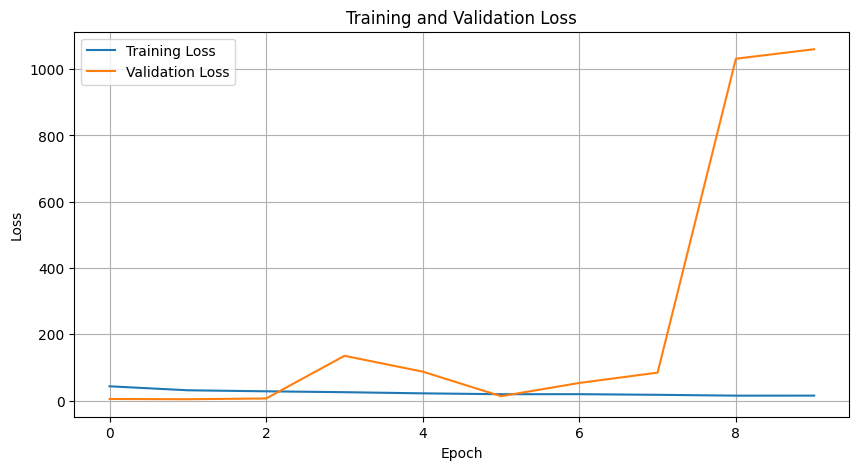

Model saved to 'v4_CNN_4hz.pth'

=== Processing 6Hz data ===
Looking for data in: e:\SteerNet\data_synced_6hz

Found 188 CSV files for 6Hz
Limiting to 60 frames per video for fair comparison


Loading 6Hz datasets:   7%|▋         | 13/188 [00:00<00:01, 124.94it/s]

CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-0

Loading 6Hz datasets:  22%|██▏       | 42/188 [00:00<00:01, 129.31it/s]

CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-29--16-37-17_4.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-29--16-37-17_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-29--16-37-17_4.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-29--16-37-17_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-30--13-03-07_14.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-30--13-03-07_14_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-30--13-03-07_14.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-07-3

Loading 6Hz datasets:  37%|███▋      | 70/188 [00:00<00:00, 132.16it/s]

CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_11.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_11.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_12.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_12_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_12.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_13.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_13_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-01--21-13-49_13.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_201

Loading 6Hz datasets:  60%|██████    | 113/188 [00:00<00:00, 135.34it/s]

CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_6.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_6.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_7.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_7_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_7.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-02--

Loading 6Hz datasets:  68%|██████▊   | 127/188 [00:00<00:00, 134.58it/s]

CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_5.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_5.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_6.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_6.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_7.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_7_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--22-42-26_7.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-10--

Loading 6Hz datasets:  82%|████████▏ | 155/188 [00:01<00:00, 133.32it/s]

CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_5.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_5.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_6.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--20-41-07_6.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-14--

Loading 6Hz datasets: 100%|██████████| 188/188 [00:01<00:00, 129.22it/s]


CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_38.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_38_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_38.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_39.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_39_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_39.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_40.csv
Frames directory: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_40_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_2018-08-17--12-07-08_40.csv
CSV file: e:\SteerNet\data_synced_6hz\b0c9d2329ad1606b_201

Epoch 1/50: 100%|██████████| 124/124 [00:32<00:00,  3.83it/s, loss=7.15]


Epoch 1: Train Loss: 56.3082, Val Loss: 10.1708


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=3.33]


Epoch 2: Train Loss: 42.0033, Val Loss: 7.4667


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.52it/s, loss=7.68]


Epoch 3: Train Loss: 35.3003, Val Loss: 32.0725


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.09it/s, loss=886] 


Epoch 4: Train Loss: 32.0714, Val Loss: 6.7557


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=4.87]


Epoch 5: Train Loss: 28.7443, Val Loss: 13.7765


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.58it/s, loss=8.36]


Epoch 6: Train Loss: 24.1434, Val Loss: 53.7176


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.19it/s, loss=49.4]


Epoch 7: Train Loss: 20.8292, Val Loss: 27.7836


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=5.92]


Epoch 8: Train Loss: 20.2119, Val Loss: 305.8353


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=14.3]


Epoch 9: Train Loss: 16.8246, Val Loss: 139.6114


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.03it/s, loss=4.16]


Epoch 10: Train Loss: 17.7911, Val Loss: 118.4280


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.55it/s, loss=17.3]


Epoch 11: Train Loss: 16.1624, Val Loss: 1514.6701


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.32it/s, loss=8.04]


Epoch 12: Train Loss: 14.4613, Val Loss: 306.5185
Early stopping triggered at epoch 12


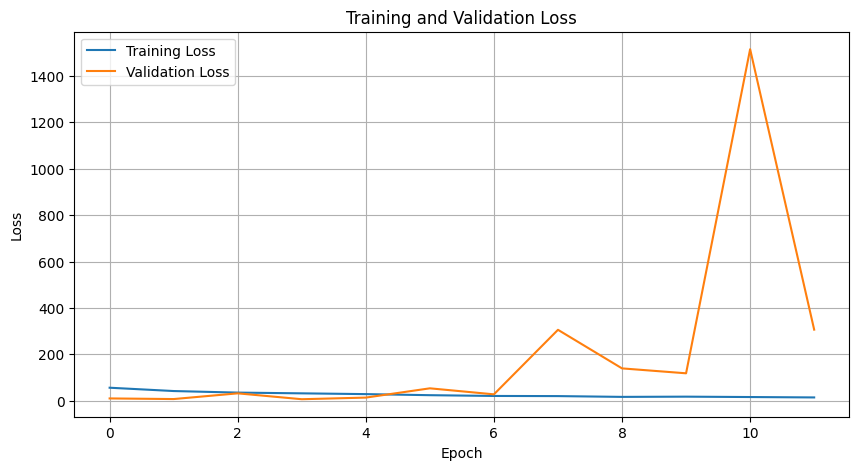

Model saved to 'v4_CNN_6hz.pth'

=== Processing 8Hz data ===
Looking for data in: e:\SteerNet\data_synced_8hz

Found 188 CSV files for 8Hz
Limiting to 60 frames per video for fair comparison


Loading 8Hz datasets:  14%|█▍        | 26/188 [00:00<00:00, 250.36it/s]

CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-0

Loading 8Hz datasets:  43%|████▎     | 80/188 [00:00<00:00, 265.11it/s]

Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_7.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_8.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_8.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_9.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-07-31--20-50-28_9.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-01--21-13-49_10.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-01--21-13-49_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e

Loading 8Hz datasets:  87%|████████▋ | 164/188 [00:00<00:00, 269.79it/s]

CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-06--10-04-53_35.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-06--10-04-53_35_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-06--10-04-53_35.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-06--10-04-53_36.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-06--10-04-53_36_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-06--10-04-53_36.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-10--22-42-26_10.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-10--22-42-26_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-10--22-42-26_10.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_201

Loading 8Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 266.01it/s]


CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_36.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_36_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_36.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_37_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_38.csv
Frames directory: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_38_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_2018-08-17--12-07-08_38.csv
CSV file: e:\SteerNet\data_synced_8hz\b0c9d2329ad1606b_201

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.52it/s, loss=3.51]


Epoch 1: Train Loss: 50.8893, Val Loss: 4.8995


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.54it/s, loss=15.4]


Epoch 2: Train Loss: 38.1161, Val Loss: 4.4015


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.14it/s, loss=5]   


Epoch 3: Train Loss: 33.8718, Val Loss: 35.3588


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.62it/s, loss=8.07]


Epoch 4: Train Loss: 31.3166, Val Loss: 7.3376


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.64it/s, loss=3.12]


Epoch 5: Train Loss: 27.9924, Val Loss: 22.9989


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.28it/s, loss=31.7]


Epoch 6: Train Loss: 23.8186, Val Loss: 31.1767


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=6.15]


Epoch 7: Train Loss: 19.7658, Val Loss: 42.9339


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.61it/s, loss=12.3]


Epoch 8: Train Loss: 20.8912, Val Loss: 229.9845


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.31it/s, loss=10.1]


Epoch 9: Train Loss: 16.4059, Val Loss: 23.8750


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.60it/s, loss=19.7]


Epoch 10: Train Loss: 16.7943, Val Loss: 33.0504
Early stopping triggered at epoch 10


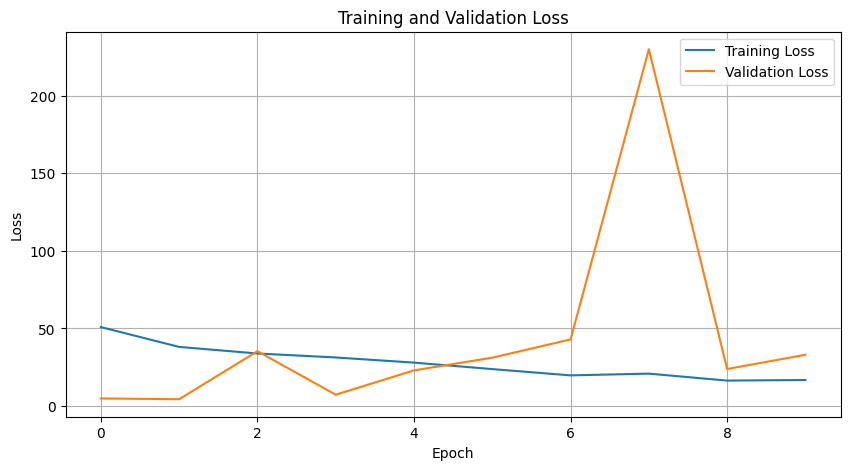

Model saved to 'v4_CNN_8hz.pth'

=== Processing 10Hz data ===
Looking for data in: e:\SteerNet\data_synced_10hz

Found 188 CSV files for 10Hz
Limiting to 60 frames per video for fair comparison


Loading 10Hz datasets:  13%|█▎        | 24/188 [00:00<00:00, 238.10it/s]

CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad16

Loading 10Hz datasets:  40%|███▉      | 75/188 [00:00<00:00, 249.32it/s]

CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-30--13-44-30_9.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-30--13-44-30_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-30--13-44-30_9.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-31--20-50-28_12.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-31--20-50-28_12_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-31--20-50-28_12.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-31--20-50-28_13.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-31--20-50-28_13_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-07-31--20-50-28_13.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad16

Loading 10Hz datasets:  68%|██████▊   | 127/188 [00:00<00:00, 254.52it/s]

CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_25.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_25_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_25.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_26.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_26_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_26.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_29.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_29_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-06--10-04-53_29.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329a

Loading 10Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 248.43it/s]


CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_5.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_5.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_6.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_6.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_8.csv
Frames directory: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_2018-08-16--21-52-30_8.csv
CSV file: e:\SteerNet\data_synced_10hz\b0c9d2329ad1606b_20

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.21it/s, loss=6.67]


Epoch 1: Train Loss: 27.1275, Val Loss: 6.2290


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.46it/s, loss=3.41]


Epoch 2: Train Loss: 17.3049, Val Loss: 2.4795


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=5.68]


Epoch 3: Train Loss: 14.6173, Val Loss: 2.3122


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.19it/s, loss=490] 


Epoch 4: Train Loss: 13.4249, Val Loss: 7.7066


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=1.65]


Epoch 5: Train Loss: 12.3639, Val Loss: 3.7747


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=3.05]


Epoch 6: Train Loss: 10.9290, Val Loss: 7.9002


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.16it/s, loss=4.79]


Epoch 7: Train Loss: 10.9600, Val Loss: 3.3838


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.44it/s, loss=17.8]


Epoch 8: Train Loss: 8.8000, Val Loss: 3.0307


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.49it/s, loss=6.36]


Epoch 9: Train Loss: 9.4696, Val Loss: 3.8741


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.00it/s, loss=3.06]


Epoch 10: Train Loss: 8.6917, Val Loss: 10.5071


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.39it/s, loss=13.2]


Epoch 11: Train Loss: 8.0999, Val Loss: 5.3086
Early stopping triggered at epoch 11


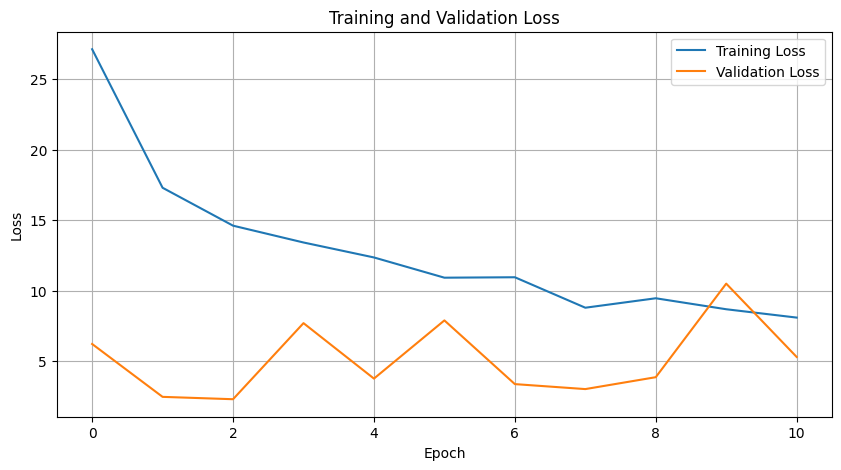

Model saved to 'v4_CNN_10hz.pth'

=== Processing 12Hz data ===
Looking for data in: e:\SteerNet\data_synced_12hz

Found 188 CSV files for 12Hz
Limiting to 60 frames per video for fair comparison


Loading 12Hz datasets:  22%|██▏       | 42/188 [00:00<00:00, 209.83it/s]

CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad16

Loading 12Hz datasets:  47%|████▋     | 89/188 [00:00<00:00, 224.38it/s]

CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_15.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_15_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_15.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_6.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_6.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_7.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_7_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-07-30--13-44-30_7.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b

Loading 12Hz datasets:  60%|██████    | 113/188 [00:00<00:00, 226.61it/s]

CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_12.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_12_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_12.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_13.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_13_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_13.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_14_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329a

Loading 12Hz datasets:  86%|████████▌ | 161/188 [00:00<00:00, 230.43it/s]

CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_15.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_15_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_15.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad16

Loading 12Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 226.44it/s]


CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_7.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_7_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_7.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_8.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_8.csv
CSV file: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_9.csv
Frames directory: e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_12hz\b0c9d2329ad1606b_2018-08-17--14-55-39_9.csv

Frame reduction summary for 12Hz:
Total frames before lim

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=12.4]


Epoch 1: Train Loss: 15.4622, Val Loss: 3.4810


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.00it/s, loss=9.36]


Epoch 2: Train Loss: 8.5376, Val Loss: 2.0060


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.36it/s, loss=2.7] 


Epoch 3: Train Loss: 7.9435, Val Loss: 2.3282


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=1.78]


Epoch 4: Train Loss: 6.6560, Val Loss: 2.1458


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 13.97it/s, loss=3.83]


Epoch 5: Train Loss: 5.7033, Val Loss: 2.5484


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=2.61]


Epoch 6: Train Loss: 5.5970, Val Loss: 4.8798


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.32it/s, loss=3.11]


Epoch 7: Train Loss: 4.6207, Val Loss: 3.9489


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.18it/s, loss=1.93]


Epoch 8: Train Loss: 4.7420, Val Loss: 7.1480


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=4.77]


Epoch 9: Train Loss: 4.5719, Val Loss: 9.3910


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=2.45]


Epoch 10: Train Loss: 4.7556, Val Loss: 72.9493
Early stopping triggered at epoch 10


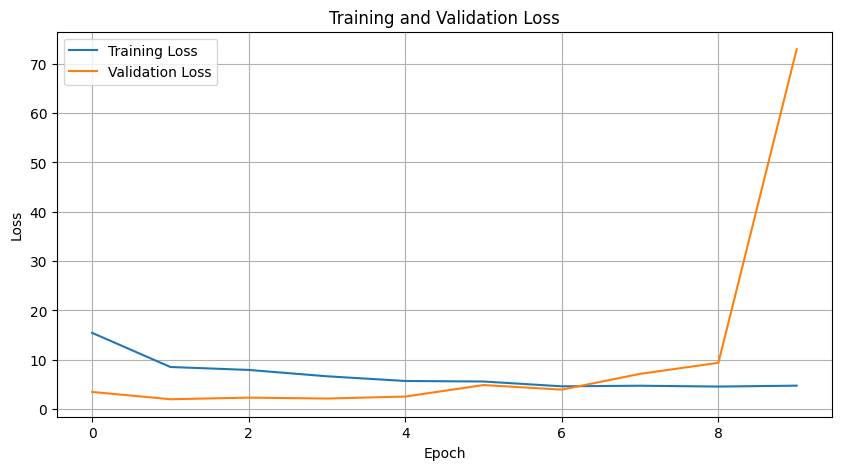

Model saved to 'v4_CNN_12hz.pth'

=== Processing 14Hz data ===
Looking for data in: e:\SteerNet\data_synced_14hz

Found 188 CSV files for 14Hz
Limiting to 60 frames per video for fair comparison


Loading 14Hz datasets:  12%|█▏        | 22/188 [00:00<00:00, 212.83it/s]

CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad16

Loading 14Hz datasets:  35%|███▌      | 66/188 [00:00<00:00, 212.17it/s]

CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_6.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_6.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_7.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_7_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_7.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_8.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-07-30--13-44-30_8.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_20

Loading 14Hz datasets:  71%|███████   | 133/188 [00:00<00:00, 217.95it/s]

CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-03--10-35-16_11.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-03--10-35-16_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-03--10-35-16_11.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad16

Loading 14Hz datasets:  95%|█████████▌| 179/188 [00:00<00:00, 220.95it/s]

CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_12.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_12_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_12.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_13.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_13_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_13.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_14.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_14_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-14--20-41-07_14.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329a

Loading 14Hz datasets: 100%|██████████| 188/188 [00:00<00:00, 217.98it/s]


CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_1.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_1_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_1.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_2.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_2_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_2.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_3.csv
Frames directory: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_2018-08-17--14-55-39_3.csv
CSV file: e:\SteerNet\data_synced_14hz\b0c9d2329ad1606b_20

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=4.8] 


Epoch 1: Train Loss: 13.5823, Val Loss: 2.3163


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.56it/s, loss=3.33]


Epoch 2: Train Loss: 6.7820, Val Loss: 2.4313


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.14it/s, loss=2.85]


Epoch 3: Train Loss: 5.9427, Val Loss: 2.7302


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.56it/s, loss=3.55]


Epoch 4: Train Loss: 5.3346, Val Loss: 2.7397


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.44it/s, loss=3.97]


Epoch 5: Train Loss: 4.7643, Val Loss: 4.0076


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.24it/s, loss=4.5] 


Epoch 6: Train Loss: 4.8841, Val Loss: 10.4512


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.49it/s, loss=8.69]


Epoch 7: Train Loss: 4.8307, Val Loss: 2.0092


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.65it/s, loss=2.51]


Epoch 8: Train Loss: 3.9202, Val Loss: 2.7346


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.20it/s, loss=4.26]


Epoch 9: Train Loss: 3.2617, Val Loss: 2.2307


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=5.11]


Epoch 10: Train Loss: 3.8686, Val Loss: 1.4068


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.63it/s, loss=2.1] 


Epoch 11: Train Loss: 3.5992, Val Loss: 2.0709


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.05it/s, loss=1.83]


Epoch 12: Train Loss: 3.5173, Val Loss: 2.0103


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.75it/s, loss=23]   


Epoch 13: Train Loss: 3.2988, Val Loss: 2.0936


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.42it/s, loss=7.34]


Epoch 14: Train Loss: 3.3811, Val Loss: 2.0112


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.03it/s, loss=1.47]


Epoch 15: Train Loss: 3.2993, Val Loss: 2.7406


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=6.44]


Epoch 16: Train Loss: 3.9321, Val Loss: 4.1109


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=3.7] 


Epoch 17: Train Loss: 3.2207, Val Loss: 4.0511


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.00it/s, loss=1.14]


Epoch 18: Train Loss: 3.5054, Val Loss: 4.9783
Early stopping triggered at epoch 18


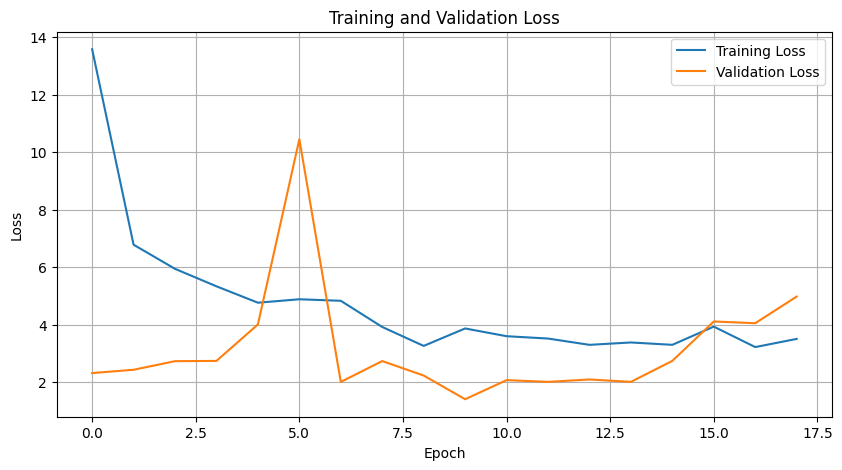

Model saved to 'v4_CNN_14hz.pth'

=== Processing 16Hz data ===
Looking for data in: e:\SteerNet\data_synced_16hz

Found 188 CSV files for 16Hz
Limiting to 60 frames per video for fair comparison


Loading 16Hz datasets:  18%|█▊        | 33/188 [00:00<00:00, 161.33it/s]

CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad16

Loading 16Hz datasets:  36%|███▌      | 67/188 [00:00<00:00, 165.08it/s]

CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_18.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_18_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_18.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_20.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_20_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_20.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_21.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_21_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-07-30--13-03-07_21.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329a

Loading 16Hz datasets:  45%|████▌     | 85/188 [00:00<00:00, 166.25it/s]

CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_32.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_32_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_32.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_33.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_33_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_33.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_34.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_34_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-02--08-34-47_34.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329a

Loading 16Hz datasets:  63%|██████▎   | 119/188 [00:00<00:00, 161.07it/s]

CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_26.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_26_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_26.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_29.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_29_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_29.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_30.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_30_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-06--10-04-53_30.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329a

Loading 16Hz datasets:  81%|████████▏ | 153/188 [00:00<00:00, 157.59it/s]

Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_13.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_14.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_14_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_14.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_15.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_15_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_15.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16_frames
Using 60 frames after limiting
Successfully loade

Loading 16Hz datasets: 100%|██████████| 188/188 [00:01<00:00, 160.45it/s]


CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--12-07-08_40.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--12-07-08_40_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--12-07-08_40.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--12-07-08_41.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--12-07-08_41_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--12-07-08_41.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--14-17-47_10.csv
Frames directory: e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--14-17-47_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_16hz\b0c9d2329ad1606b_2018-08-17--14-17-47_10.csv
CSV file: e:\SteerNet\data_synced_16hz\b0c9d2329a

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=8.58]


Epoch 1: Train Loss: 12.6288, Val Loss: 2.2271


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.35it/s, loss=5.48]


Epoch 2: Train Loss: 6.8197, Val Loss: 3.1009


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.17it/s, loss=11.2]


Epoch 3: Train Loss: 5.6353, Val Loss: 10.8902


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=53.8]


Epoch 4: Train Loss: 4.6160, Val Loss: 2.3202


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.27it/s, loss=4.01]


Epoch 5: Train Loss: 4.7226, Val Loss: 4.5164


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.49it/s, loss=9.7] 


Epoch 6: Train Loss: 4.0335, Val Loss: 2103.0668


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.51it/s, loss=4.32]


Epoch 7: Train Loss: 4.3375, Val Loss: 23.0344


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.11it/s, loss=3.48]


Epoch 8: Train Loss: 4.1802, Val Loss: 157.8524


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=4.22]


Epoch 9: Train Loss: 3.8381, Val Loss: 7.7503
Early stopping triggered at epoch 9


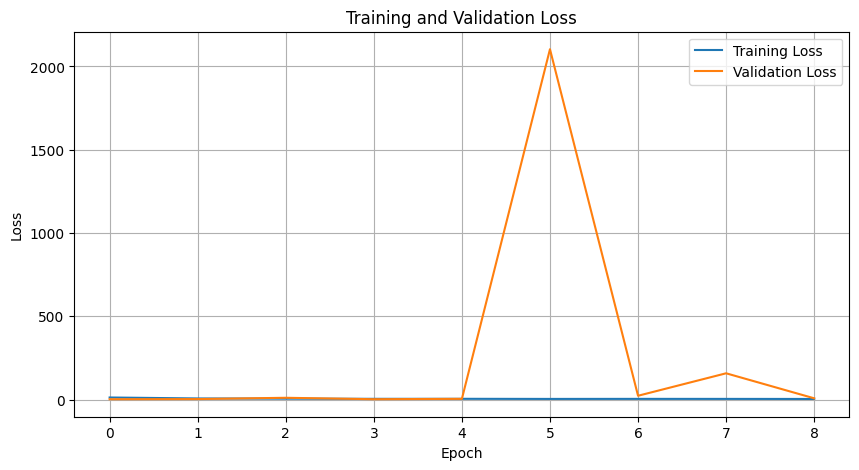

Model saved to 'v4_CNN_16hz.pth'

=== Processing 18Hz data ===
Looking for data in: e:\SteerNet\data_synced_18hz

Found 188 CSV files for 18Hz
Limiting to 60 frames per video for fair comparison


Loading 18Hz datasets:   8%|▊         | 15/188 [00:00<00:01, 146.62it/s]

CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad16

Loading 18Hz datasets:  25%|██▌       | 47/188 [00:00<00:00, 150.60it/s]

CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_15.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_15_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_15.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_16_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_17.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_17_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-07-30--13-03-07_17.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329a

Loading 18Hz datasets:  41%|████▏     | 78/188 [00:00<00:00, 145.69it/s]

CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_6.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_6.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_7.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_7_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_7.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_8.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-01--21-13-49_8.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_20

Loading 18Hz datasets:  57%|█████▋    | 108/188 [00:00<00:00, 146.91it/s]

Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_12.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_13.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_13_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_13.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_14_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_15.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-03--10-35-16_15_frames
Using 60 frames after limiting
Successfully loade

Loading 18Hz datasets:  73%|███████▎  | 138/188 [00:00<00:00, 147.15it/s]

CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_27.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_27_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_27.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_28.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_28_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_28.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_29.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_29_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-14--10-32-01_29.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329a

Loading 18Hz datasets:  89%|████████▉ | 168/188 [00:01<00:00, 147.04it/s]

CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_21.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_21_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_21.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_22.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_22_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_22.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_23.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_23_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-15--09-01-03_23.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329a

Loading 18Hz datasets: 100%|██████████| 188/188 [00:01<00:00, 147.11it/s]


Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_2.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_3.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_3.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4.csv
CSV file: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5.csv
Frames directory: e:\SteerNet\data_synced_18hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_1

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.30it/s, loss=23.6]


Epoch 1: Train Loss: 11.4469, Val Loss: 2.9886


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.06it/s, loss=2.18]


Epoch 2: Train Loss: 5.2368, Val Loss: 4.3609


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.42it/s, loss=13]  


Epoch 3: Train Loss: 5.1064, Val Loss: 2.1883


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=2.47]


Epoch 4: Train Loss: 5.0478, Val Loss: 2.3880


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.10it/s, loss=3.23]


Epoch 5: Train Loss: 4.0270, Val Loss: 1.9304


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.33it/s, loss=2.77]


Epoch 6: Train Loss: 3.4651, Val Loss: 1.9271


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=2.86]


Epoch 7: Train Loss: 3.5575, Val Loss: 1.9701


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.05it/s, loss=4.98]


Epoch 8: Train Loss: 3.5539, Val Loss: 2.1050


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.57it/s, loss=2.11]


Epoch 9: Train Loss: 3.4781, Val Loss: 3.3735


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.48it/s, loss=2.55]


Epoch 10: Train Loss: 3.2116, Val Loss: 3.1838


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.18it/s, loss=31.7]


Epoch 11: Train Loss: 3.2527, Val Loss: 2.1601


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.38it/s, loss=1.64]


Epoch 12: Train Loss: 3.4927, Val Loss: 1.7965


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.35it/s, loss=3.47]


Epoch 13: Train Loss: 3.3845, Val Loss: 2.0165


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.14it/s, loss=1.9] 


Epoch 14: Train Loss: 3.1683, Val Loss: 3.0151


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=1.99]


Epoch 15: Train Loss: 3.1350, Val Loss: 1.7728


Epoch 16/50: 100%|██████████| 124/124 [00:08<00:00, 14.27it/s, loss=1.87]


Epoch 16: Train Loss: 3.1658, Val Loss: 2.3493


Epoch 17/50: 100%|██████████| 124/124 [00:08<00:00, 14.26it/s, loss=4.66] 


Epoch 17: Train Loss: 3.1184, Val Loss: 1.7938


Epoch 18/50: 100%|██████████| 124/124 [00:08<00:00, 14.26it/s, loss=2.05]


Epoch 18: Train Loss: 2.8710, Val Loss: 2.3275


Epoch 19/50: 100%|██████████| 124/124 [00:08<00:00, 14.03it/s, loss=7.61]


Epoch 19: Train Loss: 2.6844, Val Loss: 1.8647


Epoch 20/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=2.29]


Epoch 20: Train Loss: 2.8094, Val Loss: 2.3852


Epoch 21/50: 100%|██████████| 124/124 [00:08<00:00, 14.33it/s, loss=2.75]


Epoch 21: Train Loss: 2.8158, Val Loss: 2.1103


Epoch 22/50: 100%|██████████| 124/124 [00:08<00:00, 13.96it/s, loss=4.48]


Epoch 22: Train Loss: 2.7487, Val Loss: 1.3053


Epoch 23/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=8.32]


Epoch 23: Train Loss: 2.8061, Val Loss: 2.7477


Epoch 24/50: 100%|██████████| 124/124 [00:08<00:00, 14.50it/s, loss=2.99]


Epoch 24: Train Loss: 2.5959, Val Loss: 1.7213


Epoch 25/50: 100%|██████████| 124/124 [00:08<00:00, 14.20it/s, loss=2.12] 


Epoch 25: Train Loss: 2.7424, Val Loss: 3.1872


Epoch 26/50: 100%|██████████| 124/124 [00:08<00:00, 14.38it/s, loss=6.77] 


Epoch 26: Train Loss: 2.7633, Val Loss: 2.8831


Epoch 27/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=23.8]


Epoch 27: Train Loss: 3.0109, Val Loss: 2.2588


Epoch 28/50: 100%|██████████| 124/124 [00:08<00:00, 14.07it/s, loss=1.88]


Epoch 28: Train Loss: 2.5289, Val Loss: 2.3890


Epoch 29/50: 100%|██████████| 124/124 [00:08<00:00, 14.40it/s, loss=0.971]


Epoch 29: Train Loss: 2.4614, Val Loss: 6.0963


Epoch 30/50: 100%|██████████| 124/124 [00:08<00:00, 14.18it/s, loss=1.43] 


Epoch 30: Train Loss: 2.2794, Val Loss: 1.4611
Early stopping triggered at epoch 30


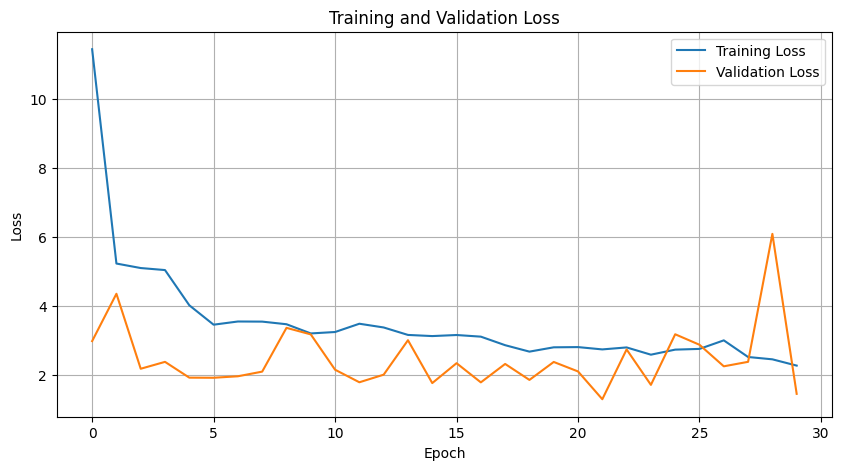

Model saved to 'v4_CNN_18hz.pth'

=== Processing 20Hz data ===
Looking for data in: e:\SteerNet\data_synced_20hz

Found 188 CSV files for 20Hz
Limiting to 60 frames per video for fair comparison


Loading 20Hz datasets:   7%|▋         | 14/188 [00:00<00:01, 134.14it/s]

CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad16

Loading 20Hz datasets:  22%|██▏       | 42/188 [00:00<00:01, 129.73it/s]

Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_29.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_30_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_31.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_31_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--12-02-42_31.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--16-37-17_4.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-07-29--16-37-17_4_frames
Using 60 frames after limiting
Successfully loaded 

Loading 20Hz datasets:  45%|████▌     | 85/188 [00:00<00:00, 137.57it/s]

CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_11.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_11.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_12.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_12_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_12.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_13.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_13_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-01--21-13-49_13.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329a

Loading 20Hz datasets:  53%|█████▎    | 99/188 [00:00<00:00, 137.08it/s]

CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-02--16-41-38_8.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-02--16-41-38_9.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-03--10-35-16_10.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b

Loading 20Hz datasets:  68%|██████▊   | 127/188 [00:00<00:00, 133.60it/s]

CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_3.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_3.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_4.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_4.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_5.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-10--22-42-26_5.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_20

Loading 20Hz datasets:  82%|████████▏ | 155/188 [00:01<00:00, 128.23it/s]

CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_16.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_4.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_5.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-14--20-41-07_5.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b

Loading 20Hz datasets:  96%|█████████▋| 181/188 [00:01<00:00, 124.31it/s]

Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_32.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_33.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_33_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_33.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_34.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_34_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_34.csv
CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_35.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--12-07-08_35_frames
Using 60 frames after limiting
Successfully loade

Loading 20Hz datasets: 100%|██████████| 188/188 [00:01<00:00, 130.27it/s]


CSV file: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--14-55-39_9.csv
Frames directory: e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--14-55-39_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_20hz\b0c9d2329ad1606b_2018-08-17--14-55-39_9.csv

Frame reduction summary for 20Hz:
Total frames before limiting: 224190
Total frames after limiting: 11280
Reduction: 95.0%

Training and evaluating model for 20Hz data...
Calculated convolutional output size: torch.Size([1, 64, 3, 8])
Flattened conv features size: 1536
Combined input size: 1600

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 124/124 [00:09<00:00, 13.71it/s, loss=4.77]


Epoch 1: Train Loss: 10.8730, Val Loss: 3.1584


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.13it/s, loss=3.9] 


Epoch 2: Train Loss: 5.0285, Val Loss: 5.2008


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 14.07it/s, loss=3.46]


Epoch 3: Train Loss: 4.2709, Val Loss: 4.3575


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.08it/s, loss=2.1] 


Epoch 4: Train Loss: 3.7123, Val Loss: 3.2980


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.34it/s, loss=5.08]


Epoch 5: Train Loss: 3.4905, Val Loss: 3.1595


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=4.8] 


Epoch 6: Train Loss: 3.3444, Val Loss: 1.6017


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.25it/s, loss=6.14]


Epoch 7: Train Loss: 3.7243, Val Loss: 1.4848


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.21it/s, loss=1.35]


Epoch 8: Train Loss: 3.7261, Val Loss: 2.8657


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 13.95it/s, loss=4.84]


Epoch 9: Train Loss: 3.1709, Val Loss: 2.5064


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.16it/s, loss=3.5] 


Epoch 10: Train Loss: 3.0946, Val Loss: 4.5114


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.30it/s, loss=2.36]


Epoch 11: Train Loss: 2.6513, Val Loss: 2.3252


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 13.93it/s, loss=6]   


Epoch 12: Train Loss: 2.6922, Val Loss: 6.1200


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.27it/s, loss=2.9] 


Epoch 13: Train Loss: 2.6489, Val Loss: 8.2748


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=1.35]


Epoch 14: Train Loss: 2.6304, Val Loss: 3.2970


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 13.93it/s, loss=2.42]


Epoch 15: Train Loss: 2.9121, Val Loss: 16.3095
Early stopping triggered at epoch 15


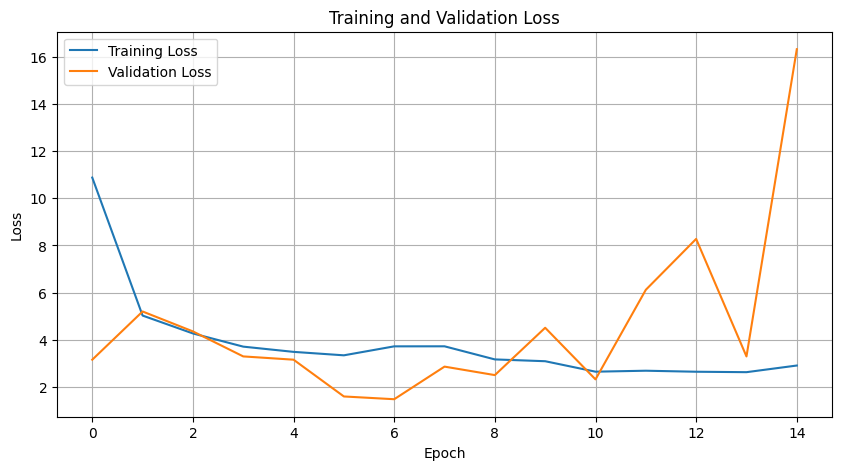

Model saved to 'v4_CNN_20hz.pth'

=== Processing 22Hz data ===
Looking for data in: e:\SteerNet\data_synced_22hz

Found 188 CSV files for 22Hz
Limiting to 60 frames per video for fair comparison


Loading 22Hz datasets:   8%|▊         | 15/188 [00:00<00:01, 144.38it/s]

CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_10.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_11.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-27--06-03-57_3.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad16

Loading 22Hz datasets:  25%|██▌       | 47/188 [00:00<00:00, 149.32it/s]

CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_14.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_14_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_14.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_15.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_15_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_15.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_16_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329a

Loading 22Hz datasets:  49%|████▉     | 93/188 [00:00<00:00, 149.14it/s]

Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_7.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_8.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_8.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_9.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_9_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-01--21-13-49_9.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-02--08-34-47_29.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-02--08-34-47_29_frames
Using 60 frames after limiting
Successfully loaded datas

Loading 22Hz datasets:  57%|█████▋    | 108/188 [00:00<00:00, 147.16it/s]

CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_16.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_16_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_16.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_4.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_4.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_5.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-03--10-35-16_5.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b

Loading 22Hz datasets:  73%|███████▎  | 138/188 [00:00<00:00, 148.42it/s]

CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_30.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_30_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_30.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_31.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_31_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_31.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_32.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_32_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-14--10-32-01_32.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329a

Loading 22Hz datasets:  90%|████████▉ | 169/188 [00:01<00:00, 145.21it/s]

CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-16--21-52-30_6.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-16--21-52-30_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-16--21-52-30_6.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-16--21-52-30_8.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-16--21-52-30_8_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-16--21-52-30_8.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--12-07-08_27.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--12-07-08_27_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--12-07-08_27.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b

Loading 22Hz datasets: 100%|██████████| 188/188 [00:01<00:00, 147.14it/s]


CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_4.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_5.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_6.csv
Frames directory: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_6_frames
Using 60 frames after limiting
Successfully loaded dataset from e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_2018-08-17--14-55-39_6.csv
CSV file: e:\SteerNet\data_synced_22hz\b0c9d2329ad1606b_20

Epoch 1/50: 100%|██████████| 124/124 [00:08<00:00, 14.10it/s, loss=3.14]


Epoch 1: Train Loss: 11.5331, Val Loss: 3.3428


Epoch 2/50: 100%|██████████| 124/124 [00:08<00:00, 14.43it/s, loss=3.47]


Epoch 2: Train Loss: 5.4592, Val Loss: 3.6356


Epoch 3/50: 100%|██████████| 124/124 [00:08<00:00, 13.99it/s, loss=2.61]


Epoch 3: Train Loss: 4.4743, Val Loss: 10.0898


Epoch 4/50: 100%|██████████| 124/124 [00:08<00:00, 14.22it/s, loss=10.3]


Epoch 4: Train Loss: 3.9722, Val Loss: 34.6374


Epoch 5/50: 100%|██████████| 124/124 [00:08<00:00, 14.41it/s, loss=3.07]


Epoch 5: Train Loss: 4.0803, Val Loss: 2.0333


Epoch 6/50: 100%|██████████| 124/124 [00:08<00:00, 14.25it/s, loss=6.79]


Epoch 6: Train Loss: 4.0692, Val Loss: 2.1846


Epoch 7/50: 100%|██████████| 124/124 [00:08<00:00, 14.52it/s, loss=12.9]


Epoch 7: Train Loss: 3.3483, Val Loss: 1.1350


Epoch 8/50: 100%|██████████| 124/124 [00:08<00:00, 14.24it/s, loss=2.94]


Epoch 8: Train Loss: 3.2138, Val Loss: 4.8369


Epoch 9/50: 100%|██████████| 124/124 [00:08<00:00, 14.29it/s, loss=2.85]


Epoch 9: Train Loss: 3.3092, Val Loss: 7.0915


Epoch 10/50: 100%|██████████| 124/124 [00:08<00:00, 14.47it/s, loss=1.17]


Epoch 10: Train Loss: 3.4297, Val Loss: 1.8132


Epoch 11/50: 100%|██████████| 124/124 [00:08<00:00, 14.21it/s, loss=1.46]


Epoch 11: Train Loss: 3.0782, Val Loss: 17.7983


Epoch 12/50: 100%|██████████| 124/124 [00:08<00:00, 14.37it/s, loss=3.18]


Epoch 12: Train Loss: 3.5882, Val Loss: 11.0018


Epoch 13/50: 100%|██████████| 124/124 [00:08<00:00, 14.31it/s, loss=2.97]


Epoch 13: Train Loss: 3.1740, Val Loss: 7.3285


Epoch 14/50: 100%|██████████| 124/124 [00:08<00:00, 14.09it/s, loss=4.91]


Epoch 14: Train Loss: 3.0807, Val Loss: 565.8346


Epoch 15/50: 100%|██████████| 124/124 [00:08<00:00, 14.55it/s, loss=3.48]


Epoch 15: Train Loss: 3.0164, Val Loss: 42.6143
Early stopping triggered at epoch 15


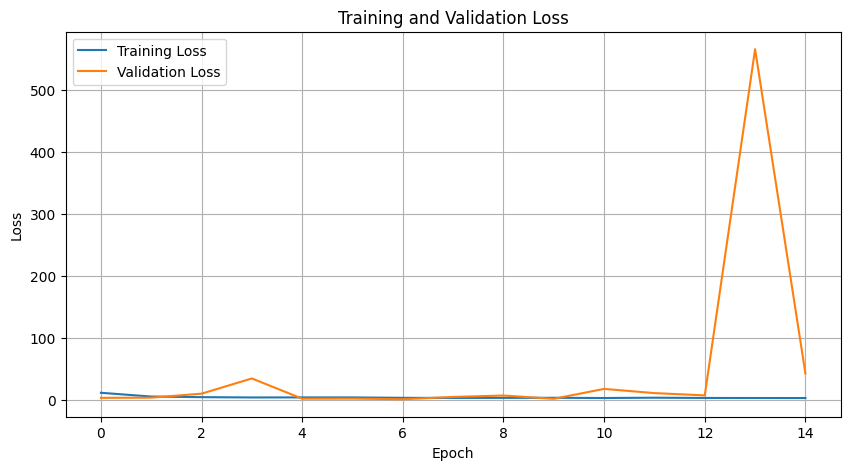

Model saved to 'v4_CNN_22hz.pth'


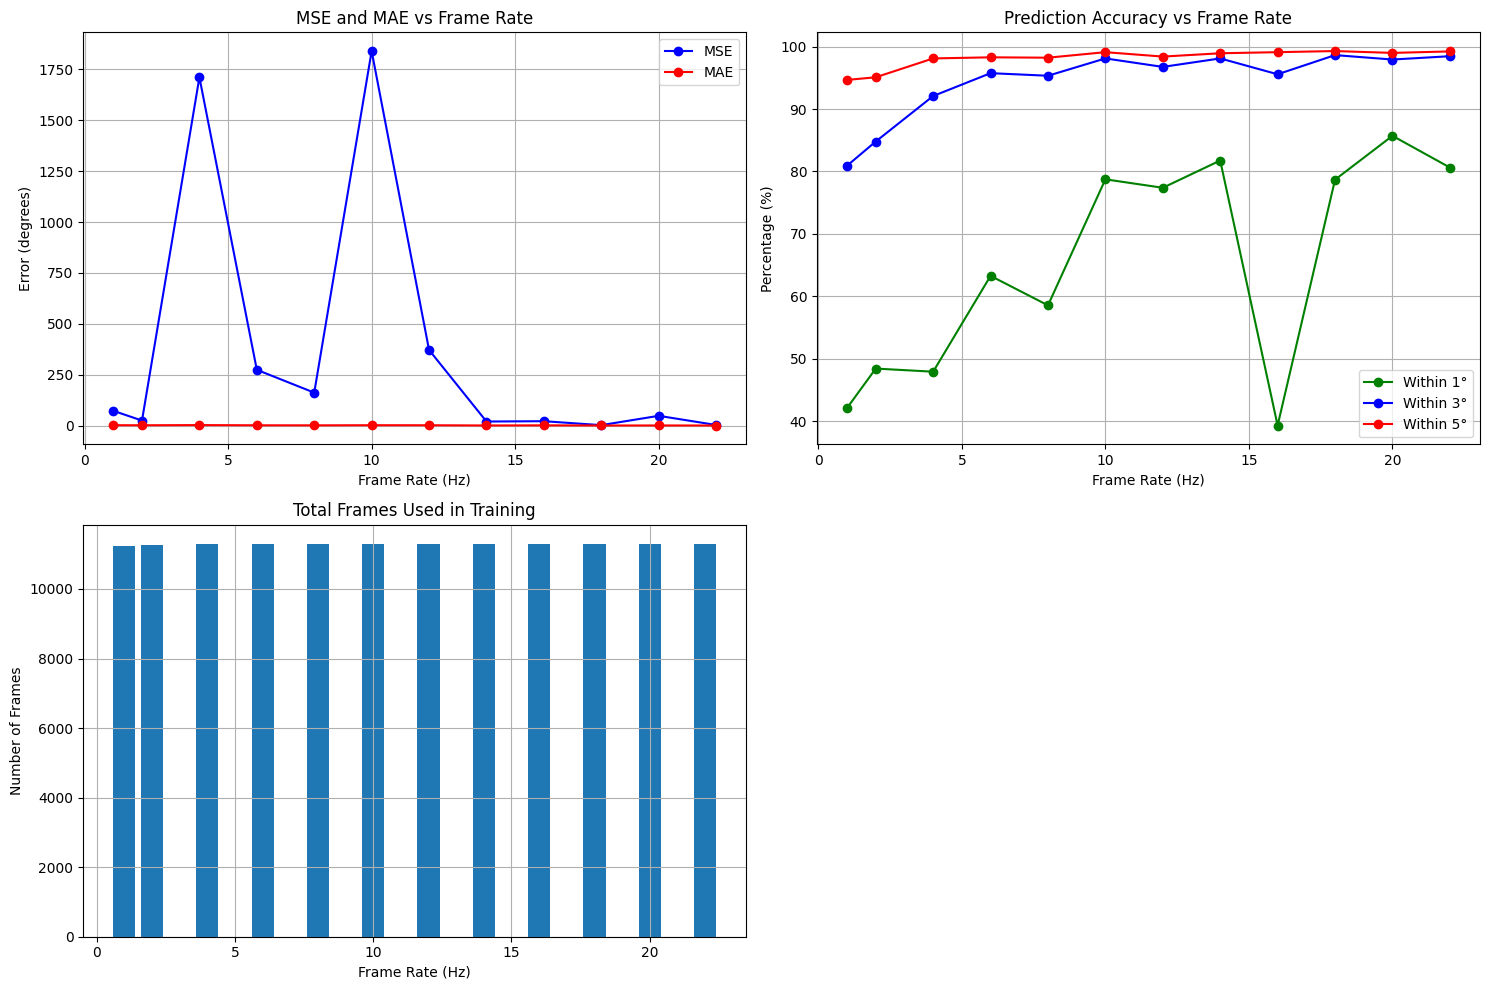


Numerical Results:

Frame Rate | Total Frames | MSE | MAE | Within 1° | Within 3° | Within 5°
--------------------------------------------------------------------------------
        1 |        11241 | 72.76 |  2.27 |     42.1 |     80.9 |     94.7
        2 |        11262 | 25.04 |  1.92 |     48.4 |     84.8 |     95.1
        4 |        11280 | 1710.52 |  2.80 |     47.9 |     92.1 |     98.1
        6 |        11280 | 274.24 |  1.83 |     63.3 |     95.7 |     98.3
        8 |        11280 | 162.02 |  1.55 |     58.5 |     95.3 |     98.2
       10 |        11280 | 1839.56 |  2.20 |     78.7 |     98.1 |     99.1
       12 |        11280 | 371.69 |  2.00 |     77.4 |     96.8 |     98.4
       14 |        11280 | 20.25 |  0.90 |     81.7 |     98.1 |     98.9
       16 |        11280 | 21.84 |  1.52 |     39.3 |     95.6 |     99.1
       18 |        11280 |  2.53 |  0.76 |     78.7 |     98.6 |     99.3
       20 |        11280 | 48.27 |  1.00 |     85.7 |     97.9 |     99.0
   

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import glob

class LimitedFramesDrivingDataset(Dataset):
    def __init__(self, csv_file, max_frames_per_video=60, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        # Get the parent directory of the CSV file
        parent_dir = os.path.dirname(csv_file)
        self.frames_dir = os.path.join(parent_dir, f"{filename[:-4]}_frames")
        
        print(f"CSV file: {csv_file}")
        print(f"Frames directory: {self.frames_dir}")
        
        # Limit frames per video
        video_groups = self.data.groupby(['frame_idx']).first().reset_index()
        if len(video_groups) > max_frames_per_video:
            kept_frame_indices = video_groups['frame_idx'].iloc[:max_frames_per_video]
            self.data = self.data[self.data['frame_idx'].isin(kept_frame_indices)]
        
        print(f"Using {len(self.data)} frames after limiting")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        # Return the length of the dataset
        return len(self.data) if hasattr(self, 'data') else 0

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")
            
        # Get frame index from data
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        
        # Load frame image
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        try:
            frame = Image.open(frame_path).convert('RGB')
        except Exception as e:
            raise Exception(f"Error loading image {frame_path}: {str(e)}")
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        # Get current sensor data (inputs)
        try:
            speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
            
            current_data = torch.tensor([
                speed_value,
                row['gyro_x'], row['gyro_y'], row['gyro_z'],
                row['accel_x'], row['accel_y'], row['accel_z'],
                row['velocity_x'], row['velocity_y'], row['velocity_z'],
                row['current_steering'],
            ], dtype=torch.float32)
            
            # Get future steering angle (target)
            target = torch.tensor(row['future_steering'], dtype=torch.float32)
            
        except Exception as e:
            raise Exception(f"Error processing row {idx}: {str(e)}")
        
        return frame, current_data, target

def load_and_prepare_data(fps):
    """Load data for specific frame rate with frame limit"""
    # Update the data directory path to match your structure
    data_dir = os.path.join(os.getcwd(), f'data_synced_{fps}hz')
    print(f"Looking for data in: {data_dir}")
    
    # Calculate max frames based on video length and 1Hz rate
    video_length_seconds = 60  # Assuming 60-second videos
    max_frames_per_video = video_length_seconds * 1  # 1 frame per second (1Hz equivalent)
    
    # Get list of all CSV files with absolute paths
    csv_pattern = os.path.join(data_dir, '*.csv')
    csv_files = [f for f in glob.glob(csv_pattern) if 'combined_dataset.csv' not in f]
    
    if not csv_files:
        print(f"No CSV files found in {data_dir}")
        raise RuntimeError(f"No CSV files found for {fps}Hz!")
    
    print(f"\nFound {len(csv_files)} CSV files for {fps}Hz")
    print(f"Limiting to {max_frames_per_video} frames per video for fair comparison")
    
    # Create datasets with frame limit
    datasets = []
    total_frames_before = 0
    total_frames_after = 0
    
    for csv_file in tqdm(csv_files, desc=f"Loading {fps}Hz datasets"):
        try:
            # Count frames before limiting
            original_data = pd.read_csv(csv_file)
            total_frames_before += len(original_data)
            
            # Create limited dataset
            dataset = LimitedFramesDrivingDataset(csv_file, max_frames_per_video=max_frames_per_video)
            total_frames_after += len(dataset)
            datasets.append(dataset)
            print(f"Successfully loaded dataset from {csv_file}")
        except Exception as e:
            print(f"Error loading {csv_file}: {str(e)}")
            continue

    if not datasets:
        raise RuntimeError(f"No datasets were successfully loaded for {fps}Hz!")

    print(f"\nFrame reduction summary for {fps}Hz:")
    print(f"Total frames before limiting: {total_frames_before}")
    print(f"Total frames after limiting: {total_frames_after}")
    print(f"Reduction: {((total_frames_before - total_frames_after) / total_frames_before * 100):.1f}%")

    # Combine all datasets
    full_dataset = ConcatDataset(datasets)
    total_size = len(full_dataset)

    # Split dataset
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader


frame_rates = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
results = {
    'mse': [],
    'mae': [],
    'within_1_deg': [],
    'within_3_deg': [],
    'within_5_deg': [],
    'total_frames': []  # Added to track number of frames used
}

def train_and_evaluate(fps, train_loader, val_loader, test_loader):
    """
    Train and evaluate the model for a specific frame rate using existing functions
    """
    print(f"\nTraining and evaluating model for {fps}Hz data...")
    
    # Initialize model and training components
    model = SteeringAngleCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train the model using existing train_model function
    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=50,
        patience=8
    )
    
    # Test the model using existing test_model function
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    metrics = {
        'mse': float(np.mean((all_preds - all_targets) ** 2)),
        'mae': float(np.mean(np.abs(all_preds - all_targets))),
        'within_1_deg': float(np.mean(np.abs(all_preds - all_targets) < 1.0) * 100),
        'within_3_deg': float(np.mean(np.abs(all_preds - all_targets) < 3.0) * 100),
        'within_5_deg': float(np.mean(np.abs(all_preds - all_targets) < 5.0) * 100)
    }
    
    # Save model for this frame rate
    torch.save(model.state_dict(), f'v4_CNN_{fps}hz.pth')
    print(f"Model saved to 'v4_CNN_{fps}hz.pth'")
    
    return metrics

# Training and evaluation loop
for fps in frame_rates:
    try:
        print(f"\n=== Processing {fps}Hz data ===")
        train_loader, val_loader, test_loader = load_and_prepare_data(fps)
        
        # Store total frames used
        results['total_frames'].append(
            len(train_loader.dataset) + 
            len(val_loader.dataset) + 
            len(test_loader.dataset)
        )
        
        # Use existing training and evaluation functions
        metrics = train_and_evaluate(fps, train_loader, val_loader, test_loader)
        for key in results:
            if key != 'total_frames':
                results[key].append(metrics[key])
                
    except Exception as e:
        print(f"Error processing {fps}Hz: {str(e)}")
        # Add None values to maintain array length
        for key in results:
            results[key].append(None)

# Create plots (same as before)
plt.figure(figsize=(15, 10))

# Plot 1: MSE and MAE
plt.subplot(2, 2, 1)
plt.plot(frame_rates, results['mse'], 'b-o', label='MSE')
plt.plot(frame_rates, results['mae'], 'r-o', label='MAE')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Error (degrees)')
plt.title('MSE and MAE vs Frame Rate')
plt.grid(True)
plt.legend()

# Plot 2: Accuracy within degree thresholds
plt.subplot(2, 2, 2)
plt.plot(frame_rates, results['within_1_deg'], 'g-o', label='Within 1°')
plt.plot(frame_rates, results['within_3_deg'], 'b-o', label='Within 3°')
plt.plot(frame_rates, results['within_5_deg'], 'r-o', label='Within 5°')
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Percentage (%)')
plt.title('Prediction Accuracy vs Frame Rate')
plt.grid(True)
plt.legend()

# Plot 3: Total frames used
plt.subplot(2, 2, 3)
plt.bar(frame_rates, results['total_frames'])
plt.xlabel('Frame Rate (Hz)')
plt.ylabel('Number of Frames')
plt.title('Total Frames Used in Training')
plt.grid(True)

plt.tight_layout()
plt.savefig('frame_rate_comparison_fair.png')
plt.show()

# Print numerical results with frame counts
print("\nNumerical Results:")
print("\nFrame Rate | Total Frames | MSE | MAE | Within 1° | Within 3° | Within 5°")
print("-" * 80)
for i, fps in enumerate(frame_rates):
    print(f"{fps:9d} | {results['total_frames'][i]:12d} | {results['mse'][i]:5.2f} | {results['mae'][i]:5.2f} | "
          f"{results['within_1_deg'][i]:8.1f} | {results['within_3_deg'][i]:8.1f} | "
          f"{results['within_5_deg'][i]:8.1f}")